In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential
from sklearn import metrics

In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

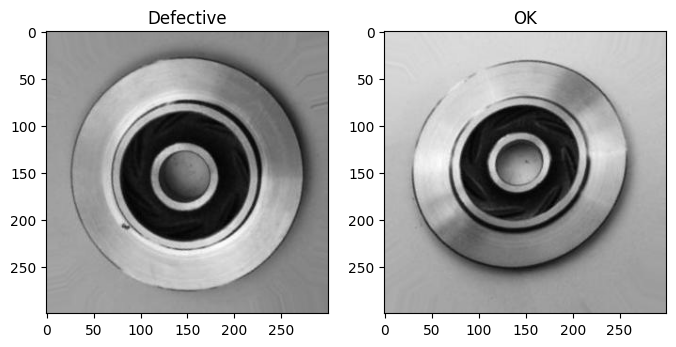

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

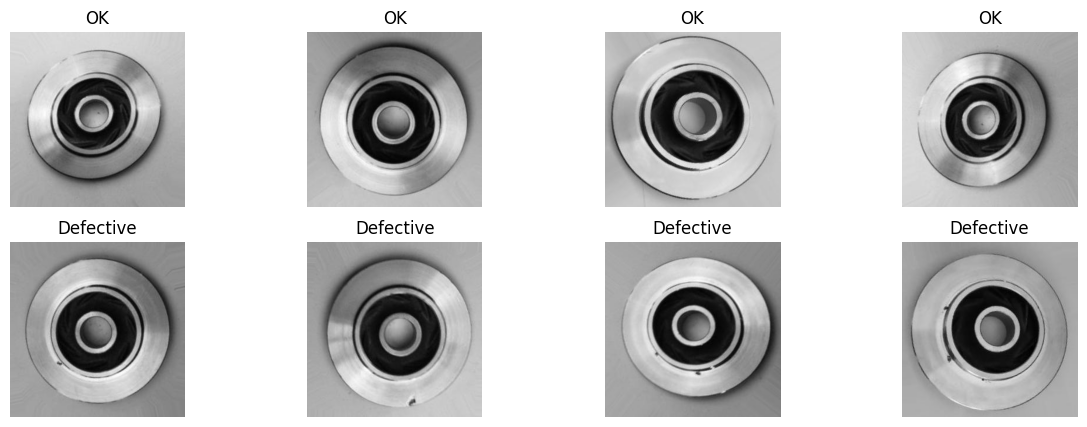

In [ ]:
num_images = 4
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defective')
    axs[1,i].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()


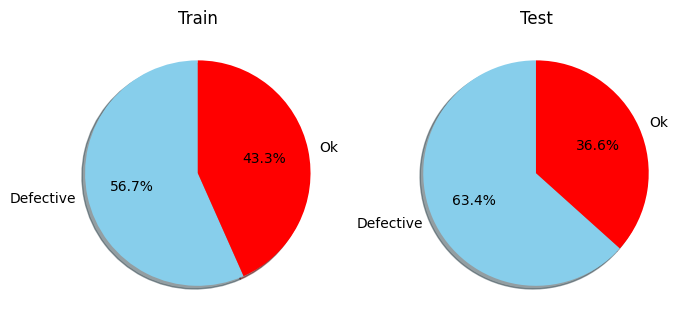

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [ ]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
colors = ['skyblue', 'red']

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

## Data loading and preprocessing



In [ ]:
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3)
test_idg = ImageDataGenerator(rescale=1./255)
img_size = (300, 300)
batch_size = 64
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## CNN

In [ ]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

### Bulding model

In [ ]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnn = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      52,429,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,290,793 (279.58 MB)

 Trainable params: 52,429,313 (200.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Training

In [ ]:
history = cnn.fit(
    train,
    validation_data=valid,
    epochs=3,
    steps_per_epoch=10,
    verbose = 1
    )

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9541 - loss: 0.1124 - val_accuracy: 0.9638 - val_loss: 0.1009
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9674 - loss: 0.1069 - val_accuracy: 0.9764 - val_loss: 0.0729
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9713 - loss: 0.0799 - val_accuracy: 0.9799 - val_loss: 0.0714


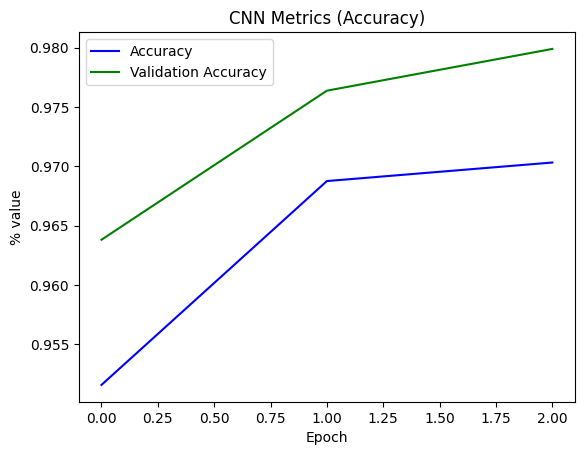

In [ ]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

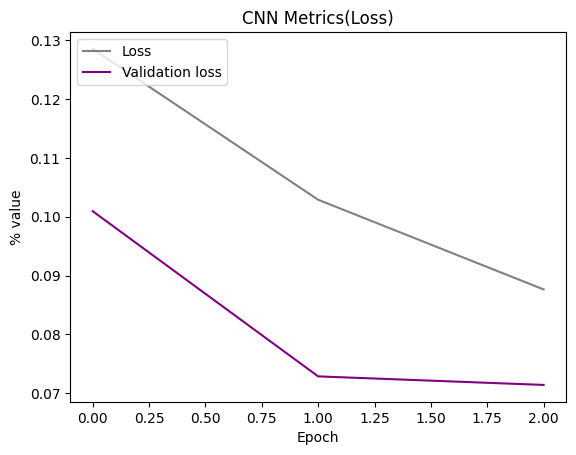

In [ ]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

### Testing and evaluation

In [ ]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


In [ ]:
y_actual = test.classes[test.index_array]

#### Confusion matrix

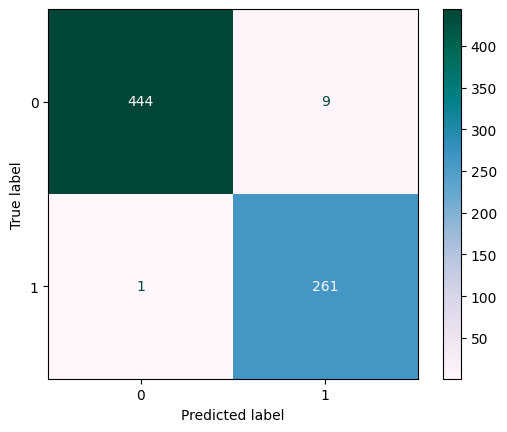

In [ ]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

#### Classification report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9801    0.9889       453
           1     0.9667    0.9962    0.9812       262

    accuracy                         0.9860       715
   macro avg     0.9822    0.9882    0.9850       715
weighted avg     0.9864    0.9860    0.9861       715

